# SET ENVIRONMENT

In [3]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os
from sklearn import preprocessing
import pandas as pd
import scipy.signal
import pickle
import csv
import random

In [ ]:
# Random seed for reproducibility
seed = 27

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/AI_in_Medicine_Project/

# CALLBACKS

In [5]:
# Utility function to create folders and callbacks for training
from datetime import datetime


def create_folders_and_callbacks(model_name):
    exps_dir = os.path.join('experiments')
    if not os.path.exists(exps_dir):
        os.makedirs(exps_dir)

    now = datetime.now().strftime('%b%d_%H-%M-%S')

    exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)

    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]

    # Model checkpoint
    # ----------------
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(ckpt_dir, 'cp'),
        save_weights_only=False,
        save_best_only=False)
    callbacks.append(ckpt_callback)

    # Visualize Learning on Tensorboard
    # ---------------------------------
    tb_dir = os.path.join(exp_dir, 'tb_logs')
    if not os.path.exists(tb_dir):
        os.makedirs(tb_dir)

    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                                 profile_batch=0,
                                                 histogram_freq=1)
    callbacks.append(tb_callback)

    return callbacks

# MODEL 

In [6]:
import tensorflow as tf
import tensorflow.keras as tfk
from keras.models import Sequential

In [7]:
def build_lstm_model(input_shape):

    model = Sequential()
    model.add(tfk.layers.LSTM(64, return_sequences=False, input_shape=input_shape))
    model.add(tfk.layers.Dense(32, name='dense_1'))
    model.add(tfk.layers.Dense(3, activation='softmax', name='output'))

    model.summary()

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss=tfk.losses.CategoricalCrossentropy(),
                metrics=[tfk.metrics.CategoricalAccuracy()])

    return model

# Load Data

In [38]:
dataset = pd.read_csv('dataset.csv', index_col=None)
dataset = dataset.iloc[:, 1:]
dataset.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,0.1
0,-0.283299,-0.263600,-0.287308,-0.320252,-0.308638,-0.267492,-0.239162,-0.213246,-0.174633,-0.174628,-0.258918,-0.376202,-0.445668,-0.470676,-0.505284,-0.551621,-0.575885,-0.586329,-0.611759,-0.637165,-0.633619,-0.625611,-0.653099,-0.652546,-0.440570,0.087500,0.716012,1.000000,0.706180,0.047966,-0.567509,-0.886688,-0.931206,-0.893990,-0.903365,-0.927710,-0.925005,-0.928219,-0.954931,-0.978122,-0.988625,-0.994276,-0.988838,-0.974828,-0.973372,-0.988058,-1.000000,-0.999176,-0.988819,-0.970214,-0.942617,-0.908062,-0.870304,-0.830713,-0.785741,-0.739185,-0.711519,-0.715006,-0.734607,-0.756479,-0.786041,-0.819814,-0.838976,-0.841898,-0.846225,-0.859363,-0.874458,-0.885567,-0.889713,-0.886801,N
1,-0.652404,-0.641507,-0.619037,-0.613962,-0.631233,-0.643332,-0.641352,-0.648237,-0.668237,-0.666577,-0.623620,-0.573367,-0.546704,-0.518793,-0.475080,-0.470636,-0.544778,-0.640111,-0.689017,-0.717090,-0.770664,-0.812496,-0.797160,-0.771559,-0.787937,-0.803995,-0.779532,-0.775940,-0.825585,-0.776977,-0.422255,0.220665,0.825983,1.000000,0.623988,-0.058777,-0.671221,-0.974769,-0.999288,-0.952152,-0.962756,-0.988189,-0.976976,-0.960688,-0.966331,-0.977528,-0.985853,-0.996283,-1.000000,-0.989083,-0.973181,-0.961793,-0.954681,-0.950664,-0.943615,-0.918947,-0.871757,-0.814343,-0.756348,-0.695572,-0.631718,-0.574366,-0.535972,-0.521499,-0.525274,-0.537298,-0.550773,-0.566408,-0.587956,-0.607787,N
2,-0.736180,-0.730167,-0.704406,-0.689202,-0.695008,-0.706108,-0.712779,-0.725130,-0.742473,-0.732065,-0.677413,-0.616812,-0.579917,-0.543462,-0.505416,-0.519954,-0.604608,-0.691138,-0.722995,-0.741526,-0.803950,-0.869336,-0.869454,-0.833796,-0.822811,-0.814419,-0.786057,-0.804702,-0.874063,-0.792952,-0.354952,0.343893,0.915280,1.000000,0.553581,-0.151616,-0.743585,-1.000000,-0.984966,-0.924579,-0.933193,-0.964819,-0.978333,-0.984378,-0.982639,-0.970667,-0.966970,-0.978133,-0.988314,-0.990384,-0.990958,-0.988573,-0.975118,-0.955494,-0.943909,-0.938399,-0.916503,-0.864303,-0.794060,-0.722680,-0.654250,-0.599362,-0.579870,-0.590625,-0.595612,-0.584612,-0.586253,-0.611730,-0.638351,-0.651917,N
3,-0.603599,-0.609930,-0.599367,-0.588966,-0.591858,-0.595776,-0.597399,-0.617393,-0.649250,-0.640029,-0.572423,-0.506843,-0.478307,-0.446181,-0.412073,-0.449041,-0.553808,-0.626988,-0.640675,-0.669162,-0.734120,-0.770712,-0.756978,-0.744226,-0.752962,-0.746035,-0.722150,-0.740174,-0.775039,-0.619917,-0.099520,0.599877,1.000000,0.804129,0.162656,-0.526048,-0.933745,-1.000000,-0.924205,-0.902931,-0.934899,-0.949114,-0.946460,-0.944869,-0.938798,-0.934744,-0.940931,-0.947718,-0.954278,-0.972323,-0.992237,-0.987113,-0.956924,-0.933350,-0.933414,-0.938852,-0.924832,-0.881245,-0.810983,-0.730434,-0.662369,-0.618449,-0.595928,-0.586014,-0.581862,-0.586182,-0.603949,-0.625171,-0.635675,-0.640861,N
4,-0.602973,-0.608122,-0.596711,-0.584638,-0.583413,-0.577879,-0.565852,-0.580178,-0.615132,-0.602931,-0.529176,-0.464177,-0.431027,-0.389630,-0.366914,-0.429369,-0.537958,-0.596816,-0.613782,-0.663222,-0.735558,-0.766968,-0.766344,-0.780174,-0.790858,-0.762587,-0.733590,-0.765359,-0.797794,-0.617282,-0.074603,0.625537,1.000000,0.758961,0.083479,-0.595796,-0.962143,-1.000000,-0.926098,-0.915369,-0.950663,-0.962138,-0.952837,-0.949670,-0.954469,-0.959327,-0.959453,-0.956374,-0.957612,-0.966753,-0.975136,-0.968556,-0.947391,-0.930263,-0.924864,-0.912576,-0.876316,-0.819195,-0.746717,-0.665515,-0.603364,-0.586195,-0.597624,-0.604473,-0.604626,-0.610419,-0.616771,-0.620591,-0.636011,-0.662531,N


In [49]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Get beats and labels
X = dataset.iloc[:,:-1]
y = dataset.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)

In [50]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

NORMAL = "N"
VENTRICULAR = "V"
SUPER_VENTRICULAR = "S"

# Under and oversampling to balance the unbalanced dataset
under = RandomUnderSampler(sampling_strategy={NORMAL: 100000})
X_res, y_res = under.fit_resample(X_train, y_train)
smote = SMOTE(sampling_strategy={VENTRICULAR: 100000, SUPER_VENTRICULAR: 100000})
X_res, y_res = smote.fit_resample(X_res, y_res)

# One-hot encoding the labels
y_res = pd.get_dummies(y_res).to_numpy()
y_test = pd.get_dummies(y_test).to_numpy()

# Reshaping the
X_res = X_res.to_numpy()
X_res = X_res.reshape((X_res.shape[0], X_res.shape[1], 1))

X_test = X_test.to_numpy()
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# TRAINING & EVALUATION

In [ ]:
input_shape = (70,1)

# Create callbacks folder and the model
callbacks = create_folders_and_callbacks(model_name='LSTM_64_32')
model = build_lstm_model(input_shape)

# Train the model
history = model.fit(
    x=X_res,
    y=y_res,
    batch_size=50,
    epochs=100,
    validation_split=.1,
    callbacks=callbacks
).history


In [56]:
# Predict with this model
predictions = model.predict(X_test)
predictions

array([[9.9991417e-01, 8.3119892e-05, 2.7106214e-06],
       [9.9971884e-01, 2.8108002e-04, 1.5368517e-08],
       [8.4441078e-01, 1.4847778e-01, 7.1114241e-03],
       ...,
       [9.9725503e-01, 2.7436756e-03, 1.3160738e-06],
       [9.9070460e-01, 9.0584029e-03, 2.3704895e-04],
       [9.8338819e-01, 1.2852173e-02, 3.7596391e-03]], dtype=float32)

[Text(0, 0.5, 'N'), Text(0, 1.5, 'S'), Text(0, 2.5, 'V')]

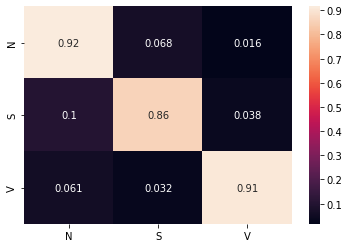

In [58]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

matrix = confusion_matrix(y_test.argmax(axis=1), 
                          predictions.argmax(axis=1), normalize='true')

# Plot the confusion matrix
fig, ax = plt.subplots()
sns.heatmap(matrix, annot=True)
ax.set_xticklabels(['N', 'S', 'V'])
ax.set_yticklabels(['N', 'S', 'V'])
